# Test MiniGrid sequential tasks with PPO + BLIP

## Setup

Default Jupyter settings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
%autoreload 2

Import libraries

In [4]:
import sys, os, time
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from datetime import date

import pickle
import torch
from arguments_rl import get_args

from collections import deque
from rl_module.a2c_ppo_acktr.envs import make_vec_envs
from rl_module.a2c_ppo_acktr.storage import RolloutStorage
from rl_module.train_ppo import train_ppo
from stable_baselines3.common.utils import set_random_seed
from torch_ac.utils import DictList
from torch.utils.tensorboard import SummaryWriter

# Gym MiniGrid specific
import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper
from gym.wrappers import Monitor

/Users/inigo/.local/share/virtualenvs/tfm-experiments-K5nk3NK1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define functions and helpers

In [5]:
# define wrapper for CNN Policies
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

def get_tb_dir(result_dir, log_name, stage='train',task_idx=0):
    tb_dir = os.path.join(result_dir, log_name, stage, "task_"+str(task_idx))
    return tb_dir

Load arguments

In [6]:
args = {
'algo':'ppo',
'experiment':'minigrid-blip-5e5-doorkey-wallgap-lavagap',
'approach':'blip', #'fine-tuning','blip','ewc'
'wrapper':'flat',#'img'
'optimizer':'Adam',#'RMSProp',#'Adam',
'gail':False,
'gail_experts_dir':'./gail_experts',
'gail_batch_size':128,
'gail_epoch':5,
'lr':2.5e-4,#7e-4,#1e-4,
'eps':1e-8,#1e-5,
'gamma':0.99,
'use_gae':True,
'gae_lambda':0.95,#0.99,
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'seed':1,
'cuda_deterministic':False,
'num_processes':16,
'num_steps':128,#5,
'ppo_epoch':4,
'num_mini_batch':256,#8,#32,
'clip_param':0.2,#0.1,
'log_interval':10,
'save_interval':10,
'eval_interval':10,
'num_env_steps':5e5,
'env_name':'PongNoFrameskip-v4',
'log_dir':'./logs/',
'save_dir':'./trained_models/',
'no_cuda':True,
'use_proper_time_limits':False,
'recurrent_policy':False,
'use_linear_lr_decay':False,
'ewc_lambda':5000.0,
'ewc_online':False,
'ewc_epochs':100,
'num_ewc_steps':20,
'save_name':None,
'date':date.today(),
'task_id':None,
'single_task':False,
'F_prior':1e-16,#5e-18,#1e-15,
'input_padding':False,
'sample':False,
'samples':1,
'num_eval_episodes':10,
# render arguments
'render_ckpt_path':'',
'render_task_idx':0,
'num_render_traj':1000
}

args = DictList(args)

args.cuda = not args.no_cuda and torch.cuda.is_available()

assert args.algo in ['a2c', 'ppo', 'acktr']
if args.recurrent_policy:
    assert args.algo in ['a2c', 'ppo'], \
        'Recurrent policy is not implemented for ACKTR'
conv_experiment = [
    'atari',
]

print(args)

{'algo': 'ppo', 'experiment': 'minigrid-blip-5e5-doorkey-wallgap-lavagap', 'approach': 'blip', 'wrapper': 'flat', 'optimizer': 'Adam', 'gail': False, 'gail_experts_dir': './gail_experts', 'gail_batch_size': 128, 'gail_epoch': 5, 'lr': 0.00025, 'eps': 1e-08, 'gamma': 0.99, 'use_gae': True, 'gae_lambda': 0.95, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'seed': 1, 'cuda_deterministic': False, 'num_processes': 16, 'num_steps': 128, 'ppo_epoch': 4, 'num_mini_batch': 256, 'clip_param': 0.2, 'log_interval': 10, 'save_interval': 10, 'eval_interval': 10, 'num_env_steps': 500000.0, 'env_name': 'PongNoFrameskip-v4', 'log_dir': './logs/', 'save_dir': './trained_models/', 'no_cuda': True, 'use_proper_time_limits': False, 'recurrent_policy': False, 'use_linear_lr_decay': False, 'ewc_lambda': 5000.0, 'ewc_online': False, 'ewc_epochs': 100, 'num_ewc_steps': 20, 'save_name': None, 'date': datetime.date(2023, 11, 6), 'task_id': None, 'single_task': False, 'F_prior': 1e-16, 'inpu

Load tasks and model

In [7]:
# Split

if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    log_name = '{}_{}_{}_{}'.format(args.date, args.experiment, args.approach,args.seed)
elif args.approach == 'ewc' in args.approach:
    log_name = '{}_{}_{}_{}_lamb_{}'.format(args.date, args.experiment, args.approach, args.seed, args.ewc_lambda)
elif args.approach == 'blip':
    log_name = '{}_{}_{}_{}_F_prior_{}'.format(args.date, args.experiment, args.approach, args.seed, args.F_prior)

if args.experiment in conv_experiment:
    log_name = log_name + '_conv'

# Seed
set_random_seed(args.seed)

# Inits
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

device = torch.device("cuda" if args.cuda else "cpu")

#taskcla = [(0,14), (1,18), (2,18), (3,18), (4,18), (5,6)]
#task_sequences = [(0, 'KungFuMasterNoFrameskip-v4'), (1, 'BoxingNoFrameskip-v4'), (2, 'JamesbondNoFrameskip-v4'), (3, 'KrullNoFrameskip-v4'), (4, 'RiverraidNoFrameskip-v4'), (5, 'SpaceInvadersNoFrameskip-v4')]

taskcla = [(0,7), (1,7), (2,7)]
tasks_sequence = [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0')
    ]

# hard coded for atari environment
#obs_shape = (4,84,84)

# for FlatObsWrapper Minigrid environment
if args.wrapper == 'flat':
    wrapper_class = FlatObsWrapper
    obs_shape = (2739,)
# for ImgRGBImgPartialObsWrapper Minigrid environment
elif args.wrapper == 'img':
    wrapper_class = ImgRGBImgPartialObsWrapper
    obs_shape = (12, 56, 56)

if args.approach == 'blip':
    from rl_module.ppo_model import QPolicy
    print('using fisher prior of: ', args.F_prior)
    actor_critic = QPolicy(obs_shape,
        taskcla,
        base_kwargs={'F_prior': args.F_prior, 'recurrent': args.recurrent_policy}).to(device)
else:
    from rl_module.ppo_model import Policy
    actor_critic = Policy(obs_shape,
        taskcla,
        base_kwargs={'recurrent': args.recurrent_policy}).to(device)

# Args -- Approach
if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    from rl_module.ppo import PPO as approach

    agent = approach(actor_critic,
            args.clip_param,
            args.ppo_epoch,
            args.num_mini_batch,
            args.value_loss_coef,
            args.entropy_coef,
            lr=args.lr,
            eps=args.eps,
            max_grad_norm=args.max_grad_norm,
            use_clipped_value_loss=True,
            optimizer=args.optimizer)
elif args.approach == 'ewc':
    from rl_module.ppo_ewc import PPO_EWC as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        ewc_lambda= args.ewc_lambda,
        online = args.ewc_online,
        optimizer=args.optimizer)

elif args.approach == 'blip':
    from rl_module.ppo_blip import PPO_BLIP as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        optimizer=args.optimizer)

using fisher prior of:  1e-16


Train:

In [7]:
print('Device: ', device)
print('Approach: ', args.approach)
print('Date: ', args.date)
print('Experiment: ', log_name)
print('Length task sequence: ', len(tasks_sequence))
print('Tasks: ', tasks_sequence, '\n')

tr_reward_arr = []
te_reward_arr = {}

for _type in (['mean', 'max', 'min', 'std']):
    te_reward_arr[_type] = {}
    for idx in range(len(taskcla)):
        te_reward_arr[_type]['task' + str(idx)] = []

# Define Tensorboard loggers

tb_logger_train = {
    'header':["update", "num_timesteps", "FPS", "mean_reward", "median_reward", "min_reward", "max_reward", "std", "entropy", "value_loss", "action_loss"],
    'writer':SummaryWriter(os.path.join("./result_data/", log_name, "train"))
}

tb_logger_eval = {
    'header':["update", "num_timesteps", "mean_reward", "min_reward", "max_reward", "std"],
    'writer':[]
}

for idx in range(len(taskcla)):
    tb_logger_eval['writer'].append(SummaryWriter(os.path.join("./result_data/", log_name, "eval", "task_"+str(idx))))

# Start training 

prev_total_num_steps = 0 

for task_idx,env_name in tasks_sequence:
    print('Training task '+str(task_idx)+': '+env_name)
    # renew optimizer
    agent.renew_optimizer()

    # FlatObsWrapper for MiniGrid
    envs = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=wrapper_class)
    obs = envs.reset()

    rollouts = RolloutStorage(args.num_steps, args.num_processes,
                                    obs_shape, envs.action_space,
                                    actor_critic.recurrent_hidden_state_size)

    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)
    num_updates = int(args.num_env_steps) // args.num_steps // args.num_processes

    current_total_num_steps = train_ppo(actor_critic, agent, rollouts, task_idx, env_name, tasks_sequence, envs,  obs_shape, args, episode_rewards, tr_reward_arr, te_reward_arr, tb_logger_train, tb_logger_eval, num_updates, log_name, device, prev_total_num_steps, wrapper_class=wrapper_class)

    prev_total_num_steps = current_total_num_steps

    # post-processing
    if args.approach == 'fine-tuning':
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ft-fix':
        # fix the backbone
        for param in actor_critic.features.parameters():
            param.requires_grad = False
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ewc':
        agent.update_fisher(rollouts, task_idx)
        envs.close()
    elif args.approach == 'blip':
        agent.ng_post_processing(rollouts, task_idx)
        # save the model here so that bit allocation is saved
        save_path = os.path.join(args.save_dir, args.algo)
        torch.save(actor_critic.state_dict(),
            os.path.join(save_path, log_name + '_task_' + str(task_idx) + ".pth"))
        envs.close()

Device:  cpu
Approach:  blip
Date:  2023-10-05
Experiment:  2023-10-05_minigrid-blip-5e5-doorkey-wallgap-lavagap_blip_1_F_prior_1e-16
Length task sequence:  3
Tasks:  [(0, 'MiniGrid-DoorKey-6x6-v0'), (1, 'MiniGrid-WallGapS6-v0'), (2, 'MiniGrid-LavaGapS6-v0')] 

Training task 0: MiniGrid-DoorKey-6x6-v0
Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



  4%|▎         | 9/244 [00:50<20:20,  5.19s/it]

Updates 9, num timesteps 20480, FPS 367 
 Last 10 training episodes: mean/median reward 0.1/0.0, min/max reward 0.0/0.7, std 0.3



  4%|▍         | 10/244 [01:10<36:58,  9.48s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



  8%|▊         | 19/244 [02:00<20:44,  5.53s/it]

Updates 19, num timesteps 40960, FPS 324 
 Last 10 training episodes: mean/median reward 0.4/0.5, min/max reward 0.0/0.8, std 0.3



  8%|▊         | 20/244 [02:20<36:54,  9.89s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 12%|█▏        | 29/244 [03:11<23:00,  6.42s/it]

Updates 29, num timesteps 61440, FPS 310 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0



 12%|█▏        | 30/244 [03:30<36:36, 10.26s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96700, std 0.00458 



 16%|█▌        | 39/244 [04:21<19:22,  5.67s/it]

Updates 39, num timesteps 81920, FPS 307 
 Last 10 training episodes: mean/median reward 0.9/1.0, min/max reward 0.9/1.0, std 0.0



 16%|█▋        | 40/244 [04:43<36:15, 10.67s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 20%|██        | 49/244 [05:35<18:23,  5.66s/it]

Updates 49, num timesteps 102400, FPS 300 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 20%|██        | 50/244 [05:52<29:12,  9.03s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96650, std 0.00735 



 24%|██▍       | 59/244 [06:44<19:40,  6.38s/it]

Updates 59, num timesteps 122880, FPS 298 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 25%|██▍       | 60/244 [07:03<31:28, 10.26s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96175, std 0.00251 



 28%|██▊       | 69/244 [07:51<15:59,  5.48s/it]

Updates 69, num timesteps 143360, FPS 300 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 29%|██▊       | 70/244 [08:12<28:48,  9.93s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96025, std 0.00720 



 32%|███▏      | 79/244 [09:04<16:43,  6.08s/it]

Updates 79, num timesteps 163840, FPS 297 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 33%|███▎      | 80/244 [09:24<28:22, 10.38s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96050, std 0.00630 



 36%|███▋      | 89/244 [10:17<16:03,  6.22s/it]

Updates 89, num timesteps 184320, FPS 295 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 37%|███▋      | 90/244 [10:36<25:51, 10.07s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96425, std 0.00537 



 41%|████      | 99/244 [11:34<15:18,  6.34s/it]

Updates 99, num timesteps 204800, FPS 291 
 Last 10 training episodes: mean/median reward 0.9/1.0, min/max reward 0.0/1.0, std 0.3



 41%|████      | 100/244 [11:53<23:56,  9.98s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96675, std 0.00434 



 45%|████▍     | 109/244 [12:41<13:17,  5.91s/it]

Updates 109, num timesteps 225280, FPS 292 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 45%|████▌     | 110/244 [13:05<25:56, 11.61s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 49%|████▉     | 119/244 [13:50<10:47,  5.18s/it]

Updates 119, num timesteps 245760, FPS 294 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 49%|████▉     | 120/244 [14:05<16:57,  8.21s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.94300, std 0.01187 



 53%|█████▎    | 129/244 [14:50<09:41,  5.06s/it]

Updates 129, num timesteps 266240, FPS 297 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 53%|█████▎    | 130/244 [15:09<17:01,  8.96s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 57%|█████▋    | 139/244 [15:53<08:47,  5.02s/it]

Updates 139, num timesteps 286720, FPS 299 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 57%|█████▋    | 140/244 [16:11<15:41,  9.05s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 61%|██████    | 149/244 [16:56<07:56,  5.02s/it]

Updates 149, num timesteps 307200, FPS 300 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 61%|██████▏   | 150/244 [17:14<13:56,  8.90s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 65%|██████▌   | 159/244 [17:57<07:01,  4.96s/it]

Updates 159, num timesteps 327680, FPS 302 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 66%|██████▌   | 160/244 [18:13<11:31,  8.23s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.95425, std 0.00448 



 69%|██████▉   | 169/244 [18:57<06:03,  4.85s/it]

Updates 169, num timesteps 348160, FPS 304 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 70%|██████▉   | 170/244 [19:16<10:59,  8.92s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 73%|███████▎  | 179/244 [19:59<05:17,  4.89s/it]

Updates 179, num timesteps 368640, FPS 306 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 74%|███████▍  | 180/244 [20:15<08:40,  8.13s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96475, std 0.00394 



 77%|███████▋  | 189/244 [20:59<04:29,  4.90s/it]

Updates 189, num timesteps 389120, FPS 307 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 78%|███████▊  | 190/244 [21:18<08:04,  8.96s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 82%|████████▏ | 199/244 [22:01<03:41,  4.92s/it]

Updates 199, num timesteps 409600, FPS 308 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 82%|████████▏ | 200/244 [22:17<05:57,  8.11s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96150, std 0.00391 



 86%|████████▌ | 209/244 [23:01<02:52,  4.92s/it]

Updates 209, num timesteps 430080, FPS 310 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 86%|████████▌ | 210/244 [23:17<04:42,  8.31s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96150, std 0.00421 



 90%|████████▉ | 219/244 [24:01<02:01,  4.84s/it]

Updates 219, num timesteps 450560, FPS 311 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 90%|█████████ | 220/244 [24:19<03:26,  8.62s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 94%|█████████▍| 229/244 [25:02<01:13,  4.88s/it]

Updates 229, num timesteps 471040, FPS 312 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0, std 0.0



 94%|█████████▍| 230/244 [25:20<02:02,  8.76s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 98%|█████████▊| 239/244 [26:03<00:24,  4.85s/it]

Updates 239, num timesteps 491520, FPS 313 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0, std 0.0



 98%|█████████▊| 240/244 [26:18<00:32,  8.05s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96150, std 0.00539 



100%|██████████| 244/244 [26:38<00:00,  6.55s/it]
/Users/inigo/.local/share/virtualenvs/tfm-experiments-K5nk3NK1/lib/python3.7/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Training task 1: MiniGrid-WallGapS6-v0
Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



  4%|▎         | 9/244 [00:45<19:11,  4.90s/it]

Updates 9, num timesteps 20480, FPS 409 
 Last 10 training episodes: mean/median reward 0.3/0.3, min/max reward 0.0/0.8, std 0.3

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



  4%|▍         | 10/244 [01:12<45:49, 11.75s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



  8%|▊         | 19/244 [01:56<19:23,  5.17s/it]

Updates 19, num timesteps 40960, FPS 336 
 Last 10 training episodes: mean/median reward 0.6/0.5, min/max reward 0.0/0.9, std 0.3

Task 0: Evaluation using 10 episodes: mean reward 0.94900, std 0.00515 



  8%|▊         | 20/244 [02:23<43:58, 11.78s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 12%|█▏        | 29/244 [03:08<18:40,  5.21s/it]

Updates 29, num timesteps 61440, FPS 317 
 Last 10 training episodes: mean/median reward 0.6/0.8, min/max reward 0.0/1.0, std 0.4

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 12%|█▏        | 30/244 [03:35<41:31, 11.64s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95750, std 0.01392 



 16%|█▌        | 39/244 [04:20<17:57,  5.25s/it]

Updates 39, num timesteps 81920, FPS 308 
 Last 10 training episodes: mean/median reward 0.8/0.9, min/max reward 0.6/1.0, std 0.1

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 16%|█▋        | 40/244 [04:45<38:37, 11.36s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94938, std 0.01884 



 20%|██        | 49/244 [05:31<16:53,  5.20s/it]

Updates 49, num timesteps 102400, FPS 304 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/1.0, std 0.1

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 20%|██        | 50/244 [05:57<37:42, 11.66s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.09375, std 0.28125 



 24%|██▍       | 59/244 [06:42<15:55,  5.16s/it]

Updates 59, num timesteps 122880, FPS 301 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 25%|██▍       | 60/244 [07:09<35:53, 11.70s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94500, std 0.01992 



 28%|██▊       | 69/244 [07:54<15:04,  5.17s/it]

Updates 69, num timesteps 143360, FPS 298 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 29%|██▊       | 70/244 [08:20<33:32, 11.57s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95375, std 0.01431 



 32%|███▏      | 79/244 [09:05<14:22,  5.23s/it]

Updates 79, num timesteps 163840, FPS 297 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94900, std 0.00515 



 33%|███▎      | 80/244 [09:32<31:53, 11.67s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95750, std 0.01305 



 36%|███▋      | 89/244 [10:17<13:24,  5.19s/it]

Updates 89, num timesteps 184320, FPS 296 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.7/1.0, std 0.1

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 37%|███▋      | 90/244 [10:44<29:56, 11.66s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95062, std 0.01201 



 41%|████      | 99/244 [11:29<12:37,  5.23s/it]

Updates 99, num timesteps 204800, FPS 294 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/0.9, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 41%|████      | 100/244 [11:56<28:23, 11.83s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95188, std 0.01010 



 45%|████▍     | 109/244 [12:43<12:14,  5.44s/it]

Updates 109, num timesteps 225280, FPS 293 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 45%|████▌     | 110/244 [13:09<25:54, 11.60s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95188, std 0.01010 



 49%|████▉     | 119/244 [13:54<10:47,  5.18s/it]

Updates 119, num timesteps 245760, FPS 292 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 49%|████▉     | 120/244 [14:20<23:58, 11.60s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95687, std 0.01201 



 53%|█████▎    | 129/244 [15:06<10:01,  5.23s/it]

Updates 129, num timesteps 266240, FPS 291 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 53%|█████▎    | 130/244 [15:33<22:37, 11.91s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94813, std 0.01187 



 57%|█████▋    | 139/244 [16:19<09:07,  5.21s/it]

Updates 139, num timesteps 286720, FPS 291 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 57%|█████▋    | 140/244 [16:45<19:59, 11.53s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95500, std 0.01420 



 61%|██████    | 149/244 [17:30<08:21,  5.28s/it]

Updates 149, num timesteps 307200, FPS 291 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 61%|██████▏   | 150/244 [17:56<18:02, 11.51s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01677 



 65%|██████▌   | 159/244 [18:41<07:17,  5.15s/it]

Updates 159, num timesteps 327680, FPS 290 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 66%|██████▌   | 160/244 [19:08<16:23, 11.70s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01281 



 69%|██████▉   | 169/244 [19:53<06:24,  5.12s/it]

Updates 169, num timesteps 348160, FPS 290 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 70%|██████▉   | 170/244 [20:19<14:05, 11.43s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.93750, std 0.01152 



 73%|███████▎  | 179/244 [21:04<05:37,  5.20s/it]

Updates 179, num timesteps 368640, FPS 290 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/0.9, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 74%|███████▍  | 180/244 [21:30<12:23, 11.62s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94125, std 0.01287 



 77%|███████▋  | 189/244 [22:15<04:46,  5.21s/it]

Updates 189, num timesteps 389120, FPS 290 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.6/1.0, std 0.1

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 78%|███████▊  | 190/244 [22:42<10:33, 11.74s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94688, std 0.01348 



 82%|████████▏ | 199/244 [23:27<04:01,  5.37s/it]

Updates 199, num timesteps 409600, FPS 289 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 82%|████████▏ | 200/244 [23:54<08:39, 11.81s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94938, std 0.01800 



 86%|████████▌ | 209/244 [24:40<03:05,  5.29s/it]

Updates 209, num timesteps 430080, FPS 289 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 86%|████████▌ | 210/244 [25:06<06:29, 11.44s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 90%|████████▉ | 219/244 [25:51<02:10,  5.22s/it]

Updates 219, num timesteps 450560, FPS 289 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 90%|█████████ | 220/244 [26:18<04:40, 11.68s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



 94%|█████████▍| 229/244 [27:04<01:18,  5.24s/it]

Updates 229, num timesteps 471040, FPS 289 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 94%|█████████▍| 230/244 [27:30<02:41, 11.56s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94875, std 0.01649 



 98%|█████████▊| 239/244 [28:15<00:26,  5.31s/it]

Updates 239, num timesteps 491520, FPS 288 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 



 98%|█████████▊| 240/244 [28:43<00:47, 11.99s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94875, std 0.01649 



100%|██████████| 244/244 [29:03<00:00,  7.15s/it]


Training task 2: MiniGrid-LavaGapS6-v0
Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



  4%|▎         | 9/244 [00:46<20:12,  5.16s/it]

Updates 9, num timesteps 20480, FPS 393 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



  4%|▍         | 10/244 [01:23<58:22, 14.97s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



  8%|▊         | 19/244 [02:10<20:36,  5.50s/it]

Updates 19, num timesteps 40960, FPS 302 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



  8%|▊         | 20/244 [02:46<55:22, 14.83s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 12%|█▏        | 29/244 [03:34<19:59,  5.58s/it]

Updates 29, num timesteps 61440, FPS 280 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 12%|█▏        | 30/244 [04:11<54:26, 15.26s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 16%|█▌        | 39/244 [04:58<18:35,  5.44s/it]

Updates 39, num timesteps 81920, FPS 269 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 16%|█▋        | 40/244 [05:34<50:12, 14.77s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 20%|██        | 49/244 [06:22<17:44,  5.46s/it]

Updates 49, num timesteps 102400, FPS 264 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 20%|██        | 50/244 [06:59<48:13, 14.91s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 24%|██▍       | 59/244 [07:45<17:03,  5.53s/it]

Updates 59, num timesteps 122880, FPS 260 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 25%|██▍       | 60/244 [08:22<45:37, 14.88s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 28%|██▊       | 69/244 [09:09<16:29,  5.66s/it]

Updates 69, num timesteps 143360, FPS 258 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 29%|██▊       | 70/244 [09:46<43:48, 15.11s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 32%|███▏      | 79/244 [10:33<15:03,  5.47s/it]

Updates 79, num timesteps 163840, FPS 256 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



 33%|███▎      | 80/244 [11:10<40:41, 14.89s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 36%|███▋      | 89/244 [11:57<14:14,  5.51s/it]

Updates 89, num timesteps 184320, FPS 255 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 37%|███▋      | 90/244 [12:33<38:01, 14.82s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 41%|████      | 99/244 [13:20<13:17,  5.50s/it]

Updates 99, num timesteps 204800, FPS 254 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 41%|████      | 100/244 [13:57<36:01, 15.01s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 45%|████▍     | 109/244 [14:46<12:39,  5.63s/it]

Updates 109, num timesteps 225280, FPS 252 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 45%|████▌     | 110/244 [15:25<35:07, 15.73s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 49%|████▉     | 119/244 [16:13<11:55,  5.72s/it]

Updates 119, num timesteps 245760, FPS 251 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 49%|████▉     | 120/244 [16:50<31:17, 15.14s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 53%|█████▎    | 129/244 [17:36<10:32,  5.50s/it]

Updates 129, num timesteps 266240, FPS 250 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 53%|█████▎    | 130/244 [18:14<28:32, 15.02s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 57%|█████▋    | 139/244 [19:00<09:33,  5.46s/it]

Updates 139, num timesteps 286720, FPS 250 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



 57%|█████▋    | 140/244 [19:37<25:39, 14.81s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 61%|██████    | 149/244 [20:23<08:35,  5.43s/it]

Updates 149, num timesteps 307200, FPS 249 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 61%|██████▏   | 150/244 [21:00<23:18, 14.88s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 65%|██████▌   | 159/244 [21:47<07:44,  5.46s/it]

Updates 159, num timesteps 327680, FPS 249 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 66%|██████▌   | 160/244 [22:23<20:44, 14.81s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 69%|██████▉   | 169/244 [23:10<06:48,  5.44s/it]

Updates 169, num timesteps 348160, FPS 249 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



 70%|██████▉   | 170/244 [23:46<18:12, 14.76s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 73%|███████▎  | 179/244 [24:33<05:54,  5.45s/it]

Updates 179, num timesteps 368640, FPS 249 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



 74%|███████▍  | 180/244 [25:10<15:49, 14.84s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 77%|███████▋  | 189/244 [25:56<05:02,  5.49s/it]

Updates 189, num timesteps 389120, FPS 249 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 78%|███████▊  | 190/244 [26:33<13:20, 14.83s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 82%|████████▏ | 199/244 [27:20<04:06,  5.48s/it]

Updates 199, num timesteps 409600, FPS 248 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



 82%|████████▏ | 200/244 [27:56<10:51, 14.81s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 86%|████████▌ | 209/244 [28:43<03:12,  5.51s/it]

Updates 209, num timesteps 430080, FPS 248 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95000, std 0.01452 



 86%|████████▌ | 210/244 [29:20<08:25, 14.88s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 90%|████████▉ | 219/244 [30:07<02:19,  5.59s/it]

Updates 219, num timesteps 450560, FPS 248 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.5, std 0.1

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 90%|█████████ | 220/244 [30:44<05:57, 14.89s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 94%|█████████▍| 229/244 [31:32<01:24,  5.66s/it]

Updates 229, num timesteps 471040, FPS 248 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 94%|█████████▍| 230/244 [32:10<03:35, 15.37s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



 98%|█████████▊| 239/244 [32:57<00:27,  5.52s/it]

Updates 239, num timesteps 491520, FPS 247 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0, std 0.0

Task 0: Evaluation using 10 episodes: mean reward 0.94850, std 0.00527 

Task 1: Evaluation using 10 episodes: mean reward 0.95063, std 0.01324 



 98%|█████████▊| 240/244 [33:33<00:59, 14.82s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.00000, std 0.00000 



100%|██████████| 244/244 [33:55<00:00,  8.34s/it]


Save full model (with last task training)

In [9]:
torch.save(actor_critic,
            os.path.join(save_path, log_name + '_fullmodel_task_' + str(task_idx) + ".pth"))

Test load full model

In [ ]:
actor_critic_test = torch.load(os.path.join(save_path, log_name + '_fullmodel_task_' + str(task_idx) + ".pth"))

Evaluate

In [22]:
from rl_module.evaluation import evaluate
args.seed = 1
print(tasks_sequence)
task_idx = tasks_sequence[-1][0]
ob_rms = None

print('Evaluating tasks:')
tot_eval_episode_mean_rewards = []

eval_episode_mean_rewards = evaluate(actor_critic, ob_rms, tasks_sequence, args.seed,
                            args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=wrapper_class, episodes=100)
tot_eval_episode_mean_rewards.append(eval_episode_mean_rewards)                          

[(0, 'MiniGrid-DoorKey-6x6-v0'), (1, 'MiniGrid-WallGapS6-v0'), (2, 'MiniGrid-LavaGapS6-v0')]
Evaluating tasks:
Task 0: Evaluation using 100 episodes: mean reward 0.10870, std 0.30053 

Task 1: Evaluation using 100 episodes: mean reward 0.41300, std 0.45655 

Task 2: Evaluation using 100 episodes: mean reward 0.00000, std 0.00000 



In [8]:
from rl_module.evaluation import evaluate

print(tasks_sequence)
task_idx = tasks_sequence[-1][0]
ob_rms = None
seed_list = [100,200,300]

print('Evaluating tasks:')
tot_eval_episode_mean_rewards = []
for i in range(3):
    eval_episode_mean_rewards = evaluate(actor_critic, ob_rms, tasks_sequence, seed_list[i],
                                args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=wrapper_class, episodes=100)
    tot_eval_episode_mean_rewards.append(eval_episode_mean_rewards)

# Calculating the median of the means by column
median_of_means = np.median(np.array([d['mean'] for d in tot_eval_episode_mean_rewards]), axis=0)

# print('Final evaluation')
for i, value in enumerate(median_of_means):
    print('Task ',i,': median reward (3 eval) ', value)                               

[(0, 'MiniGrid-DoorKey-6x6-v0'), (1, 'MiniGrid-WallGapS6-v0'), (2, 'MiniGrid-LavaGapS6-v0')]
Evaluating tasks:
Task 0: Evaluation using 100 episodes: mean reward 0.54983, std 0.46367 

Task 1: Evaluation using 100 episodes: mean reward 0.90500, std 0.13578 

Task 2: Evaluation using 100 episodes: mean reward 0.00000, std 0.00000 

Task 0: Evaluation using 100 episodes: mean reward 0.39288, std 0.45843 

Task 1: Evaluation using 100 episodes: mean reward 0.94019, std 0.02658 

Task 2: Evaluation using 100 episodes: mean reward 0.00000, std 0.00000 

Task 0: Evaluation using 100 episodes: mean reward 0.96495, std 0.01054 

Task 1: Evaluation using 100 episodes: mean reward 0.93269, std 0.02853 

Task 2: Evaluation using 100 episodes: mean reward 0.00000, std 0.00000 

Task  0 : median reward (3 eval)  0.549825
Task  1 : median reward (3 eval)  0.9326875
Task  2 : median reward (3 eval)  0.0


In [12]:
tot_eval_episode_mean_rewards

[{'mean': [0.54955, 0.9245625, 0.5450625],
  'min': [0.0, 0.73125, 0.0],
  'max': [0.98, 0.9875, 0.95625],
  'std': [0.4636316398823531, 0.0561266355552335, 0.45612009708929735]},
 {'mean': [0.39189999999999997, 0.9400624999999999, 0.6485],
  'min': [0.0, 0.83125, 0.0],
  'max': [0.9725, 0.975, 0.95625],
  'std': [0.45809007302057964, 0.02608721849392917, 0.42740872563624616]},
 {'mean': [0.9649499999999999, 0.9290624999999999, 0.6131249999999999],
  'min': [0.9225, 0.6625, 0.0],
  'max': [0.9775, 0.98125, 0.95625],
  'std': [0.010535535107435226, 0.040806086785551976, 0.4418891440452005]}]

Save full model (with last task training)

In [ ]:
torch.save(actor_critic,
            os.path.join(save_path, log_name + '_fullmodel_task_' + str(task_idx) + ".pth"))

Test load full model

In [10]:
actor_critic_test = torch.load(os.path.join(save_path, log_name + '_fullmodel_task_' + str(task_idx) + ".pth"))

Test evaluate full loaded model

In [11]:
from rl_module.evaluation import evaluate
args.seed = 1
print(tasks_sequence)
task_idx = tasks_sequence[-1][0]
ob_rms = None

print('Evaluating tasks:')
tot_eval_episode_mean_rewards = []

eval_episode_mean_rewards = evaluate(actor_critic_test, ob_rms, task_sequences, args.seed,
                            args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=wrapper_class, episodes=100)
tot_eval_episode_mean_rewards.append(eval_episode_mean_rewards)                          

[(0, 'MiniGrid-DoorKey-6x6-v0'), (1, 'MiniGrid-WallGapS6-v0'), (2, 'MiniGrid-LavaGapS6-v0')]
Evaluating tasks:
Task 0: Evaluation using 100 episodes: mean reward 0.96388 

Task 1: Evaluation using 100 episodes: mean reward 0.92431 

Task 2: Evaluation using 100 episodes: mean reward 0.59362 



# Test MiniGrid PPO + BLIP (diff. F-prior)

Load arguments

In [ ]:
args = {
'algo':'ppo',
'experiment':'minigrid-blip-5e5-doorkey-wallgap-lavagap',
'approach':'blip', #'fine-tuning','blip','ewc'
'wrapper':'flat',#'img'
'optimizer':'Adam',#'RMSProp',#'Adam',
'gail':False,
'gail_experts_dir':'./gail_experts',
'gail_batch_size':128,
'gail_epoch':5,
'lr':2.5e-4,#7e-4,#1e-4,
'eps':1e-8,#1e-5,
'gamma':0.99,
'use_gae':True,
'gae_lambda':0.95,#0.99,
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'seed':1,
'cuda_deterministic':False,
'num_processes':16,
'num_steps':128,#5,
'ppo_epoch':4,
'num_mini_batch':256,#8,#32,
'clip_param':0.2,#0.1,
'log_interval':10,
'save_interval':10,
'eval_interval':100,
'num_env_steps':5e5,
'env_name':'PongNoFrameskip-v4',
'log_dir':'./logs/',
'save_dir':'./trained_models/',
'no_cuda':True,
'use_proper_time_limits':False,
'recurrent_policy':False,
'use_linear_lr_decay':False,
'ewc_lambda':5000.0,
'ewc_online':False,
'ewc_epochs':100,
'num_ewc_steps':20,
'save_name':None,
'date':date.today(),
'task_id':None,
'single_task':False,
'F_prior':1e-15,#5e-18,#1e-15,
'input_padding':False,
'sample':False,
'samples':1,
'num_eval_episodes':10,
# render arguments
'render_ckpt_path':'',
'render_task_idx':0,
'num_render_traj':1000
}

args = DictList(args)

args.cuda = not args.no_cuda and torch.cuda.is_available()

assert args.algo in ['a2c', 'ppo', 'acktr']
if args.recurrent_policy:
    assert args.algo in ['a2c', 'ppo'], \
        'Recurrent policy is not implemented for ACKTR'
conv_experiment = [
    'atari',
]

print(args)

Load tasks and model

In [ ]:
# Split

if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    log_name = '{}_{}_{}_{}'.format(args.date, args.experiment, args.approach,args.seed)
elif args.approach == 'ewc' in args.approach:
    log_name = '{}_{}_{}_{}_lamb_{}'.format(args.date, args.experiment, args.approach, args.seed, args.ewc_lambda)
elif args.approach == 'blip':
    log_name = '{}_{}_{}_{}_F_prior_{}'.format(args.date, args.experiment, args.approach, args.seed, args.F_prior)

if args.experiment in conv_experiment:
    log_name = log_name + '_conv'

# Seed
set_random_seed(args.seed)

# Inits
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

device = torch.device("cuda" if args.cuda else "cpu")

#taskcla = [(0,14), (1,18), (2,18), (3,18), (4,18), (5,6)]
#task_sequences = [(0, 'KungFuMasterNoFrameskip-v4'), (1, 'BoxingNoFrameskip-v4'), (2, 'JamesbondNoFrameskip-v4'), (3, 'KrullNoFrameskip-v4'), (4, 'RiverraidNoFrameskip-v4'), (5, 'SpaceInvadersNoFrameskip-v4')]

taskcla = [(0,7), (1,7), (2,7)]
tasks_sequence = [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0')
    ]

# hard coded for atari environment
#obs_shape = (4,84,84)

# for FlatObsWrapper Minigrid environment
if args.wrapper == 'flat':
    wrapper_class = FlatObsWrapper
    obs_shape = (2739,)
# for ImgRGBImgPartialObsWrapper Minigrid environment
elif args.wrapper == 'img':
    wrapper_class = ImgRGBImgPartialObsWrapper
    obs_shape = (12, 56, 56)

if args.approach == 'blip':
    from rl_module.ppo_model import QPolicy
    print('using fisher prior of: ', args.F_prior)
    actor_critic = QPolicy(obs_shape,
        taskcla,
        base_kwargs={'F_prior': args.F_prior, 'recurrent': args.recurrent_policy}).to(device)
else:
    from rl_module.ppo_model import Policy
    actor_critic = Policy(obs_shape,
        taskcla,
        base_kwargs={'recurrent': args.recurrent_policy}).to(device)

# Args -- Approach
if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    from rl_module.ppo import PPO as approach

    agent = approach(actor_critic,
            args.clip_param,
            args.ppo_epoch,
            args.num_mini_batch,
            args.value_loss_coef,
            args.entropy_coef,
            lr=args.lr,
            eps=args.eps,
            max_grad_norm=args.max_grad_norm,
            use_clipped_value_loss=True,
            optimizer=args.optimizer)
elif args.approach == 'ewc':
    from rl_module.ppo_ewc import PPO_EWC as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        ewc_lambda= args.ewc_lambda,
        online = args.ewc_online,
        optimizer=args.optimizer)

elif args.approach == 'blip':
    from rl_module.ppo_blip import PPO_BLIP as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        optimizer=args.optimizer)

Train

In [ ]:
print('Device: ', device)
print('Approach: ', args.approach)
print('Date: ', args.date)
print('Experiment: ', log_name)
print('Length task sequence: ', len(tasks_sequence))
print('Tasks: ', tasks_sequence, '\n')

tr_reward_arr = []
te_reward_arr = {}

for _type in (['mean', 'max', 'min', 'std']):
    te_reward_arr[_type] = {}
    for idx in range(len(taskcla)):
        te_reward_arr[_type]['task' + str(idx)] = []

# Define Tensorboard loggers

tb_logger_train = {
    'header':["update", "num_timesteps", "FPS", "mean_reward", "median_reward", "min_reward", "max_reward", "std", "entropy", "value_loss", "action_loss"],
    'writer':SummaryWriter(os.path.join("./result_data/", log_name, "train"))
}

tb_logger_eval = {
    'header':["update", "num_timesteps", "mean_reward", "min_reward", "max_reward", "std"],
    'writer':[]
}

for idx in range(len(taskcla)):
    tb_logger_eval['writer'].append(SummaryWriter(os.path.join("./result_data/", log_name, "eval", "task_"+str(idx))))

# Start training 

prev_total_num_steps = 0 

for task_idx,env_name in tasks_sequence:
    print('Training task '+str(task_idx)+': '+env_name)
    # renew optimizer
    agent.renew_optimizer()

    # FlatObsWrapper for MiniGrid
    envs = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=wrapper_class)
    obs = envs.reset()

    rollouts = RolloutStorage(args.num_steps, args.num_processes,
                                    obs_shape, envs.action_space,
                                    actor_critic.recurrent_hidden_state_size)

    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)
    num_updates = int(args.num_env_steps) // args.num_steps // args.num_processes

    current_total_num_steps = train_ppo(actor_critic, agent, rollouts, task_idx, env_name, tasks_sequence, envs,  obs_shape, args, episode_rewards, tr_reward_arr, te_reward_arr, tb_logger_train, tb_logger_eval, num_updates, log_name, device, prev_total_num_steps, wrapper_class=wrapper_class)

    prev_total_num_steps = current_total_num_steps

    # post-processing
    if args.approach == 'fine-tuning':
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ft-fix':
        # fix the backbone
        for param in actor_critic.features.parameters():
            param.requires_grad = False
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ewc':
        agent.update_fisher(rollouts, task_idx)
        envs.close()
    elif args.approach == 'blip':
        agent.ng_post_processing(rollouts, task_idx)
        # save the model here so that bit allocation is saved
        save_path = os.path.join(args.save_dir, args.algo)
        torch.save(actor_critic.state_dict(),
            os.path.join(save_path, log_name + '_task_' + str(task_idx) + ".pth"))
        envs.close()

Evaluate

In [ ]:
from rl_module.evaluation import evaluate
args.seed = 1
print(tasks_sequence)
task_idx = tasks_sequence[-1][0]
ob_rms = None

print('Evaluating tasks:')
tot_eval_episode_mean_rewards = []

eval_episode_mean_rewards = evaluate(actor_critic, ob_rms, tasks_sequence, args.seed,
                            args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=wrapper_class, episodes=100)
tot_eval_episode_mean_rewards.append(eval_episode_mean_rewards)     

In [ ]:
from rl_module.evaluation import evaluate
args.seed = 2
print(tasks_sequence)
task_idx = tasks_sequence[-1][0]
ob_rms = None
seed_list = [100,200,300]

print('Evaluating tasks:')
tot_eval_episode_mean_rewards = []
for i in range(3):
    eval_episode_mean_rewards = evaluate(actor_critic, ob_rms, tasks_sequence, seed_list[i],
                                args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=wrapper_class, episodes=100)
    tot_eval_episode_mean_rewards.append(eval_episode_mean_rewards)

tot_eval_episode_mean_rewards_median = np.median(np.array(tot_eval_episode_mean_rewards, ndmin=2), axis=0)

print('Final evaluation')
for i, value in enumerate(tot_eval_episode_mean_rewards_median):
    print('Task ',i,': median reward (3 eval) ', value)                               

Re-loading a model for evaluation

In [ ]:
# ./trained_models/ppo/2023-01-14_minigrid-blip-5e5-doorkey-wallgap-lavagap_blip_1_F_prior_1e-15_task_2.pth
saved_model = os.path.join(save_path, log_name + '_task_' + str(task_idx) + ".pth")
actor_critic3 = QPolicy(obs_shape,
    taskcla,
    base_kwargs={'F_prior': args.F_prior, 'recurrent': args.recurrent_policy}).to(device)   
actor_critic3.load_state_dict(torch.load(saved_model))
print('Model loaded: ', saved_model)

Re-evaluate

In [ ]:
from rl_module.evaluation import evaluate

print(tasks_sequence)
task_idx = tasks_sequence[-1][0]
ob_rms = None
seed_list = [100,200,300]

print('Evaluating tasks:')
tot_eval_episode_mean_rewards = []
for i in range(3):
    eval_episode_mean_rewards = evaluate(actor_critic, ob_rms, tasks_sequence, seed_list[i],
                                args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=wrapper_class, episodes=100)
    tot_eval_episode_mean_rewards.append(eval_episode_mean_rewards)

tot_eval_episode_mean_rewards_median = np.median(np.array(tot_eval_episode_mean_rewards, ndmin=2), axis=0)

print('Final evaluation')
for i, value in enumerate(tot_eval_episode_mean_rewards_median):
    print('Task ',i,': median reward (3 eval) ', value)                               

# Check MiniGrid vectorized environments

In [8]:
import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper
from gym.wrappers import Monitor

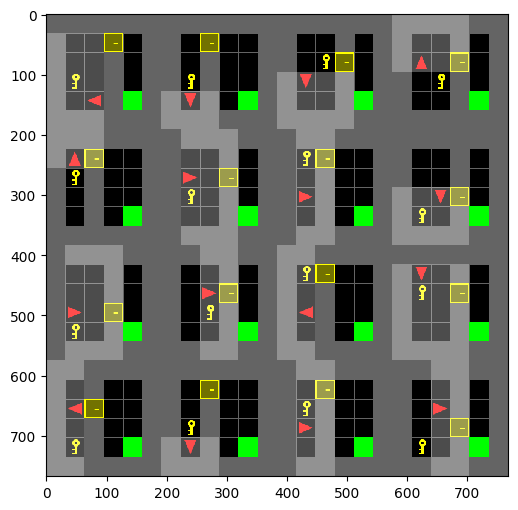

In [9]:
import matplotlib.pyplot as plt

env_name = 'MiniGrid-DoorKey-6x6-v0'

# Create vectorized environment with wrapper class
vec_env = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=FlatObsWrapper)

# Plot snapshot of vectorized environment and check randomized init
vec_env.reset()
before_img = vec_env.render('rgb_array')

plt.figure(figsize = (6.,6.))
plt.imshow(before_img);

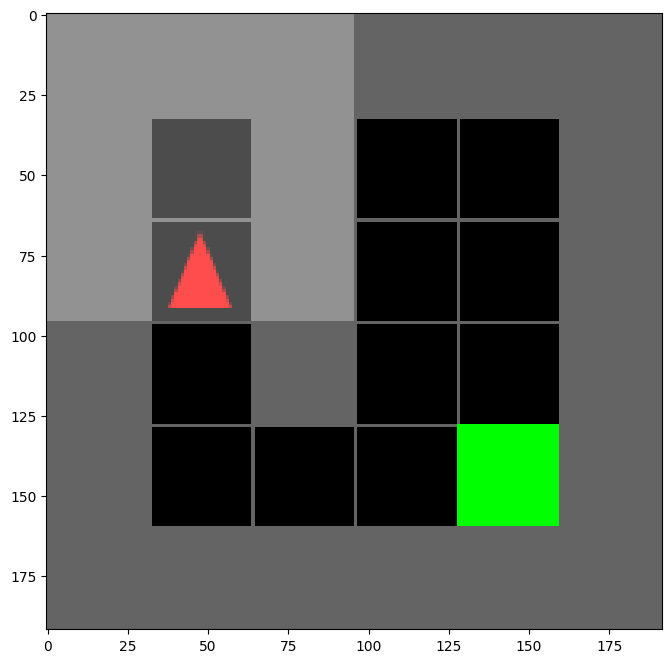

In [12]:
from random import randint
#env_id = 'MiniGrid-Empty-16x16-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'
env_id = 'MiniGrid-WallGapS6-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
before_img = eval_env.render('rgb_array')

plt.imshow(before_img);